In [1]:
import os, sys
import re
import numpy as np
import imageio as im
import pandas as pd
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
from cv2 import imwrite
from IPython.core.display import HTML
from scipy.interpolate import splprep
from scipy.interpolate import splev
from tools import skeleton_to_centerline
from cellpose import utils
from scipy.signal import find_peaks
from scipy.signal import argrelmax

cell_path = "individual_cells/"

In [2]:
def location_read(s):
    '''
    takes a string of the form '[1 2 3]' (or NaN) and outputs a list of integers [1,2,3] (or NaN)
    Parameters
    str = a string
    '''
    if type(s)!=str:
        return s
    else:
        return list(map(int,s[1:-1].split()))

In [37]:
all_the_cells = os.listdir(cell_path)

# Create a list that records the timepoints for every mask. 
time_list = []
# List of masks with associated timepoints and names
maskl = []
#a list of outlines of cell masks with timepoints and ids
outl = []
#get metadata about cells
centers = pd.DataFrame()
centers[0] = pd.read_csv('metadata/cell_id_0.csv').set_index('time')['location'].apply(location_read)
centers[1] = pd.read_csv('metadata/cell_id_1.csv').set_index('time')['location'].apply(location_read)
centers[2] = pd.read_csv('metadata/cell_id_2.csv').set_index('time')['location'].apply(location_read)
centers[3] = pd.read_csv('metadata/cell_id_3.csv').set_index('time')['location'].apply(location_read)
centers[4] = pd.read_csv('metadata/cell_id_4.csv').set_index('time')['location'].apply(location_read)
for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = int(time[0])
        time_list.append(int(time))
        im_path = cell_path + cell + '\masks'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for mask_name in os.listdir(im_path):
            ID = int(mask_name[5:6])
            mask=im.imread(im_path+'/'+mask_name)[:,:,0]>0 #the cells mask (boolean array)
            out = utils.masks_to_outlines(mask) #create the cells outline (boolean array)
            maskl.append([mask,time,ID])
            outl.append([out,int(time),ID])

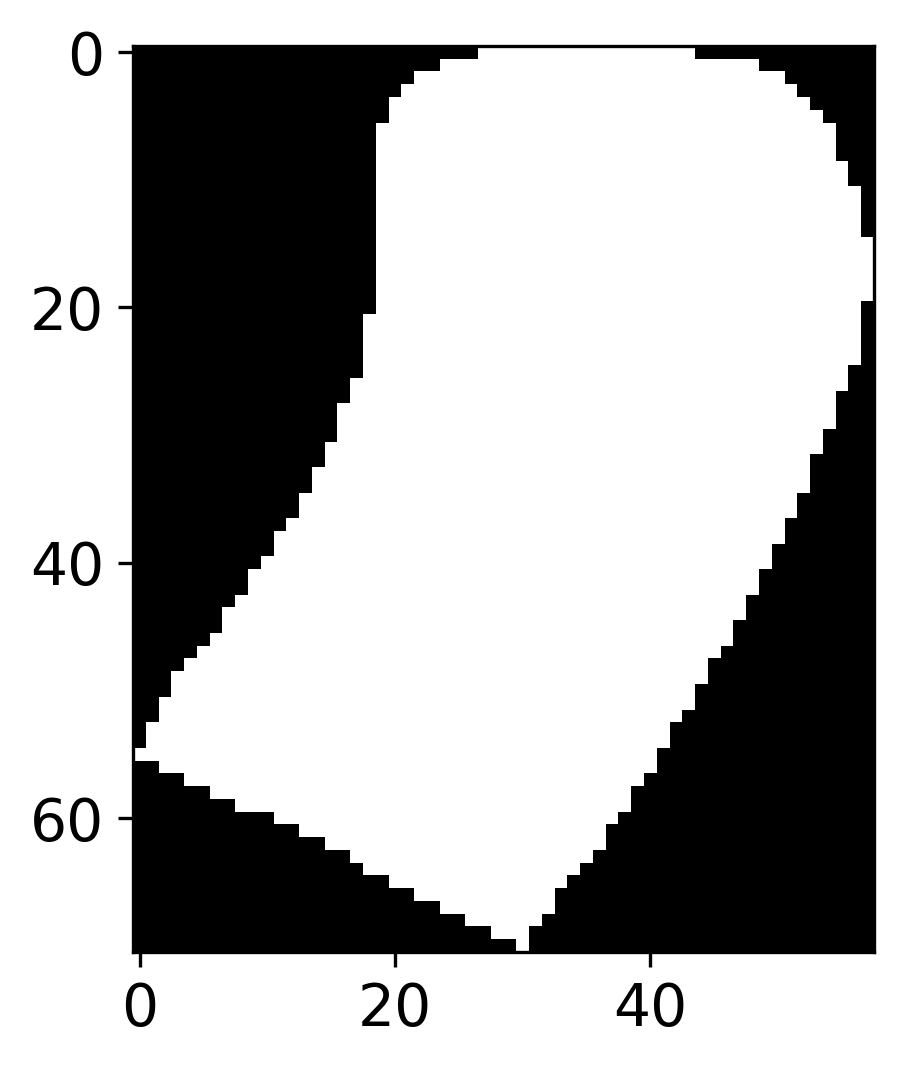

In [38]:
n=42
out = np.array(outl[n][0])
mask = np.array(maskl[n][0])
plt.imshow(mask,cmap=plt.cm.gray)

In [39]:
out = np.array(outl[n][0])
outline = skeleton_to_centerline(out)
tck,u=splprep(np.transpose(outline),per=1)
[ys,xs]=splev(u,tck)
[xo,yo]=np.transpose(outline)

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][178]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


In [40]:
def radii(x,y):
    '''
    Finds the radius function of a 2d curve
    '''
    length = len(y)
    centroid = np.array([np.sum(x),np.sum(y)])/length
    vectors = np.transpose(np.array([x,y]))-centroid
    return np.array([np.linalg.norm(v) for v in vectors]),centroid

In [41]:
def explore_poles(x,y,long=True):
    '''
    Finds the poles (average distance of the farthest points from the centroid on a smooth closed curve) from x and y coords
    Parameters
    ----------
    x = x coordinates of the curve
    y = y coordinates of the curve
    long = whether the cell is oriented lengthwise (default True)
    '''
    r,centroid = radii(x,y)
    cx = centroid[0]
    cy = centroid[1]
    peaks = argrelmax(r)[0]
    if long:
        right_poles=[]
        right_rads=[]
        left_poles=[]
        left_rads=[]
        for i in peaks:
            if x[i]>cx:
                right_poles.append(i)
                right_rads.append(r[i])
            else:
                left_poles.append(i)
                left_rads.append(r[i])
        
        average_x = np.array([np.dot([x[i] for i in right_poles],right_rads)/sum(right_rads),
                             np.dot([x[i] for i in left_poles],left_rads)/sum(left_rads)])
        average_y = np.array([np.dot([y[i] for i in right_poles],right_rads)/sum(right_rads),
                             np.dot([y[i] for i in left_poles],left_rads)/sum(left_rads)])
    else:
        lower_poles=[]
        lower_rads=[]
        upper_poles=[]
        upper_rads=[]
        for i in peaks:
            if y[i]>cy:
                lower_poles.append(i)
                lower_rads.append(r[i])
            else:
                upper_poles.append(i)
                upper_rads.append(r[i])
        
        average_x = np.array([np.dot([x[i] for i in lower_poles],lower_rads)/sum(lower_rads), 
                                       np.dot([x[i] for i in upper_poles],upper_rads)/sum(upper_rads)])
        average_y= np.array([np.dot([y[i] for i in lower_poles],lower_rads)/sum(lower_rads), 
                                       np.dot([y[i] for i in upper_poles],upper_rads)/sum(upper_rads)])
    return average_x,average_y, centroid

In [42]:
average_xo,average_yo,centroid_o=explore_poles(xo,yo,long=False)
average_xs,average_ys,centroid_s=explore_poles(xs,ys,long=False)

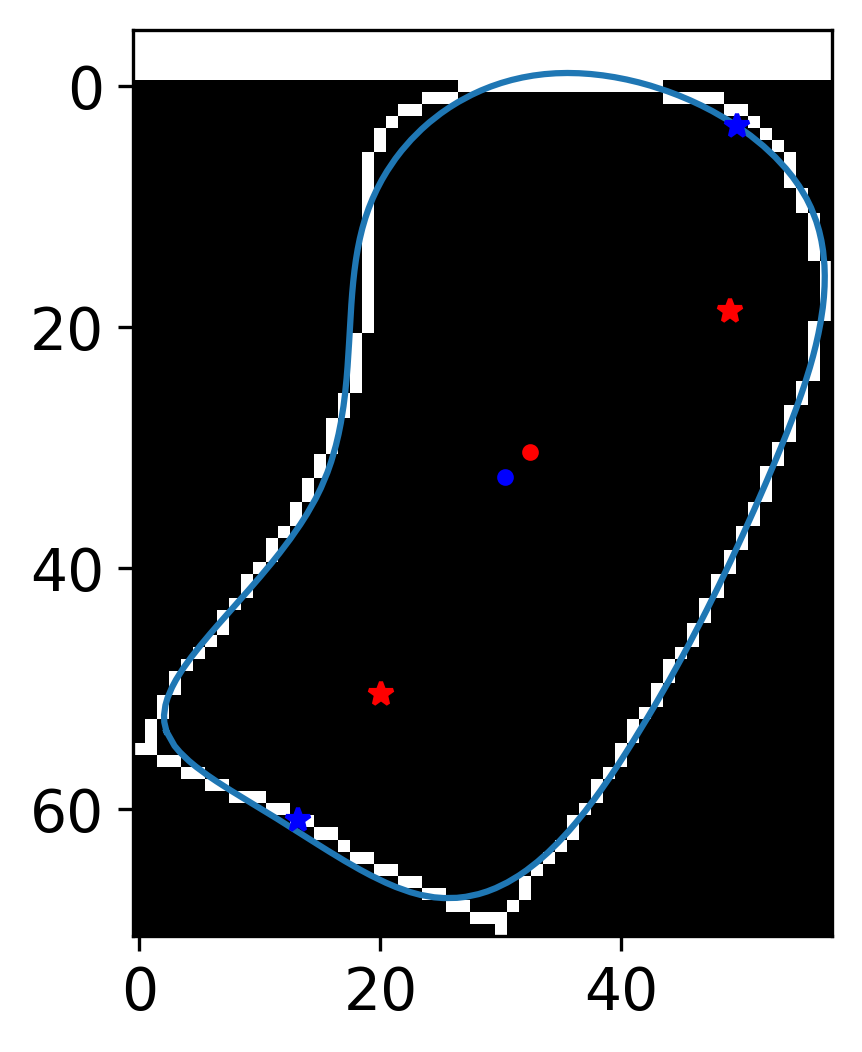

In [43]:
plt.imshow(outl[n][0],cmap=plt.cm.gray)
plt.plot(xs,ys)
plt.plot(average_xs,average_ys,'b*')
plt.plot(centroid_s[0],centroid_s[1],'b.')
plt.plot(average_xo,average_yo,'r*')
plt.plot(centroid_o[0],centroid_o[1],'r.')

In [51]:
for item in os.listdir('algorithm_comparison'):
    if item[-3]=='p' and item[-2]=='n' and item[-1]=='g':
        os.remove('algorithm_comparison'+'/'+item)
for out in outl:
    time = str(out[1])
    ID = str(out[2])
    out = np.array(out[0])
    outline = skeleton_to_centerline(np.array(out))
    tck,u=splprep(np.transpose(outline),per=1)
    [ys,xs]=splev(u,tck)
    [yo,xo]=np.transpose(outline)
    long=np.shape(out)[0]<np.shape(out)[1]
    average_xo,average_yo,centroid_o=explore_poles(xo,yo,long)
    average_xs,average_ys,centroid_s=explore_poles(xs,ys,long)
    plt.imshow(out,cmap=plt.cm.gray)
    plt.plot(xs,ys)
    plt.plot(average_xs,average_ys,'b*')
    plt.plot(centroid_s[0],centroid_s[1],'b.')
    plt.plot(average_xo,average_yo,'r*')
    plt.plot(centroid_o[0],centroid_o[1],'r.')
    plt.savefig('algorithm_comparison/' + time + '_' + ID + '.png')
    plt.clf()

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][557]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][557]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][574]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][574]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
C:\Users\sammu\AppData\Local\Temp\ipykernel_17332\3170060550.py:28: RuntimeWarning: invalid value encountered in true_divide
  np.dot([x

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][320]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][320]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][445]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][445]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting 

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][260]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][260]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][427]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][427]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
C:\Users\sammu\AppData\Local\Temp\ipykernel_17332\3170060550.py:28: RuntimeWarning: invalid value encountered in true_divide
  np.dot([x

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][112]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][112]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
C:\Users\sammu\AppData\Local\Temp\ipykernel_17332\3170060550.py:28: RuntimeWarning: invalid value encountered in true_divide
  np.dot([x[i] for i in left_poles],left_rads)/sum(left_rads)])
C:\Users\sammu\AppData\Local\Temp\ipykernel_17332\3170060550.py:30: RuntimeWarning: invalid value encountered in true_divide
  np.dot([y[i] for i in left_poles],left_rads)/sum(left_rads)])
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][231]=x[0][0]
  warnings.warn(RuntimeWarning('Sett

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][273]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][273]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][283]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][283]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting 

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][311]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][311]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][425]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][425]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting 

<Figure size 1800x1200 with 0 Axes>